<a href="https://colab.research.google.com/github/gobeomgyu/deeplearning/blob/main/RNN_LSTM_Alcohol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 4)

# 재현성
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [16]:
# 1) 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Alcohol_Sales.csv')
# 결측 제거(혹시 모를 결측치)
series = df['S4248SM144NCEN'].dropna().values.reshape(-1, 1)

# 2) 정규화
scaler = MinMaxScaler()
data = scaler.fit_transform(series)   # shape: (T, 1)

In [10]:
# 3) 시퀀스 생성 함수
def make_sequences(arr, window=12):
    X, y = [], []
    for i in range(len(arr) - window):
        X.append(arr[i:i+window])     # (window, 1)
        y.append(arr[i+window])       # (1,)
    X = np.array(X)                   # (N, window, 1)
    y = np.array(y).reshape(-1, 1)    # (N, 1)
    return X, y

window = 12
X, y = make_sequences(data, window=window)

# 4) 8:2 시간순 분할 (shuffle 금지)
n = len(X)
split = int(n * 0.8)
X_train, y_train = X[:split], y[:split]
X_test,  y_test  = X[split:], y[split:]

In [17]:
# 5) 모델 생성 함수
def build_rnn(window):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(window, 1)),
        tf.keras.layers.SimpleRNN(64, return_sequences=True),
        tf.keras.layers.SimpleRNN(32),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm(window):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(window, 1)),
        tf.keras.layers.LSTM(64),   # 마지막 출력만 사용
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [14]:
# 6) 학습 유틸
def train_and_evaluate(model, name, X_train, y_train, X_test, y_test, epochs=50, batch_size=8):
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        shuffle=False,  # 시계열
        validation_data=(X_test, y_test)
    )
    # 예측
    y_pred_tr = model.predict(X_train, verbose=1)
    y_pred_te = model.predict(X_test,  verbose=1)

    # MSE (정규화 스케일)
    tr_mse = mean_squared_error(y_train.ravel(), y_pred_tr.ravel())
    te_mse = mean_squared_error(y_test.ravel(),  y_pred_te.ravel())

    print(f'[{name}] Train MSE: {tr_mse:.6f} | Test MSE: {te_mse:.6f}')

    # 그래프: Train
    plt.figure()
    plt.title(f'{name} - Train (normalized)')
    plt.plot(y_train.ravel(), label='y_train (true)')
    plt.plot(y_pred_tr.ravel(), label='y_train (pred)')
    plt.xlabel('Time index')
    plt.ylabel('Scaled value (0~1)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 그래프: Test
    plt.figure()
    plt.title(f'{name} - Test (normalized)')
    plt.plot(y_test.ravel(), label='y_test (true)')
    plt.plot(y_pred_te.ravel(), label='y_test (pred)')
    plt.xlabel('Time index')
    plt.ylabel('Scaled value (0~1)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        'history': history,
        'tr_mse': tr_mse,
        'te_mse': te_mse,
        'y_pred_tr': y_pred_tr,
        'y_pred_te': y_pred_te
    }

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[SimpleRNN] Train MSE: 0.001183 | Test MSE: 0.002399


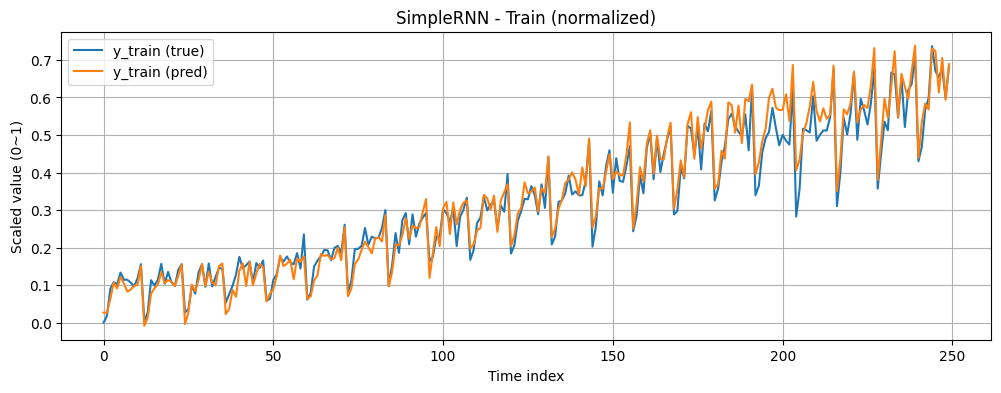

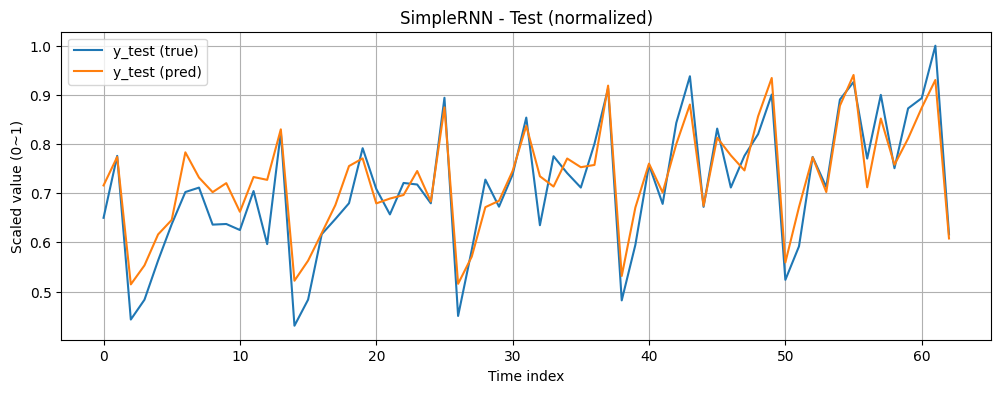

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[LSTM] Train MSE: 0.006264 | Test MSE: 0.012225


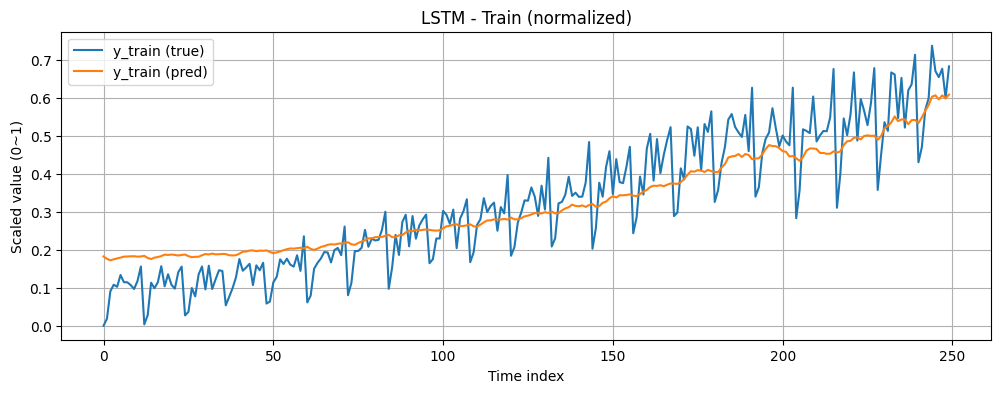

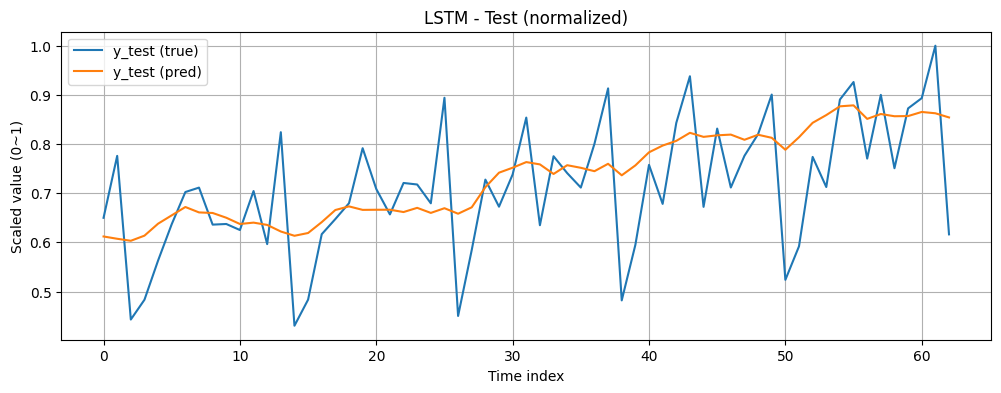


=== Summary (MSE on normalized scale) ===
SimpleRNN -> Train: 0.001183 | Test: 0.002399
LSTM     -> Train: 0.006264 | Test: 0.012225


In [15]:
# 7) 두 모델 각각 학습/평가/시각화
rnn_model  = build_rnn(window)
rnn_result = train_and_evaluate(rnn_model, 'SimpleRNN', X_train, y_train, X_test, y_test)

lstm_model  = build_lstm(window)
lstm_result = train_and_evaluate(lstm_model, 'LSTM', X_train, y_train, X_test, y_test)

# 8) 요약 출력
print('\n=== Summary (MSE on normalized scale) ===')
print(f"SimpleRNN -> Train: {rnn_result['tr_mse']:.6f} | Test: {rnn_result['te_mse']:.6f}")
print(f"LSTM     -> Train: {lstm_result['tr_mse']:.6f} | Test: {lstm_result['te_mse']:.6f}")